In [44]:
import scipy as sp
from scipy.io import loadmat
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import get_cmap
import os
from PIL import Image

In [45]:
data = loadmat("ECGData.mat")

In [46]:
data.keys(), type(data)

(dict_keys(['__header__', '__version__', '__globals__', 'ECGData']), dict)

In [47]:
data = data["ECGData"]
ecg = data["Data"][0][0]

In [48]:
labels = data["Labels"][0][0]
labels = [labels[i][0][0] for i in range(labels.size)]

In [49]:
sig_ARR, lab_ARR = ecg[0:95] , labels[0:95]
sig_CHF, lab_CHF = ecg[96:125] , labels[96:125]
sig_NSR, lab_NSR = ecg[125:161] , labels[126:161]



In [50]:
def butter_highpass_filter(data, cutoff=1, fs=128, order = 5):
    normal_cutoff = cutoff / (fs/ 2)
    b, a = signal.butter(order, normal_cutoff, btype="high", analog = False)
    y = signal.filtfilt(b, a, data)
    return y

def notch_filter(data, cutoff=60, fs=128, q = 30):
    normal_cutoff = cutoff / (fs/2)
    b, a = signal.iirnotch(normal_cutoff, Q=q, fs=fs)
    y = signal.filtfilt(b, a, data)
    return y

cutoff = 1
fs = 128

# sample = sig_ARR[0][0:1000]
# fig = plt.figure(1)
# plt.plot(sample)
# fig = plt.figure(2)
# sample_filtered = butter_highpass_filter(sample, cutoff=cutoff, fs= fs, order=5)
# plt.plot((sample_filtered))

Label: ARR	Index: 15
Label: CHF	Index: 15
Label: NSR	Index: 7


<Figure size 432x288 with 0 Axes>

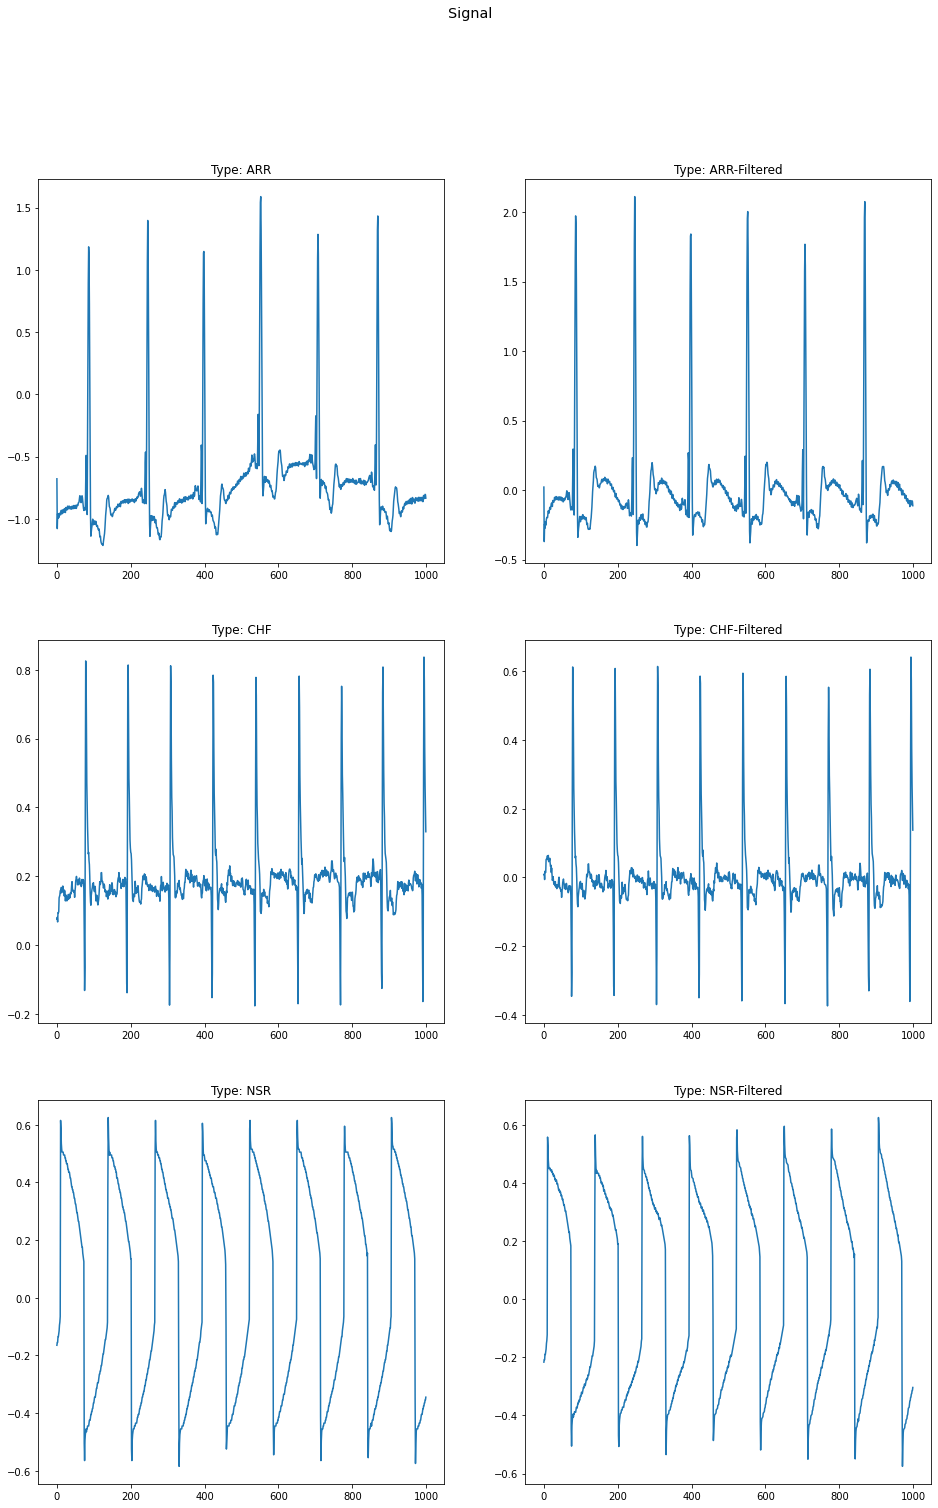

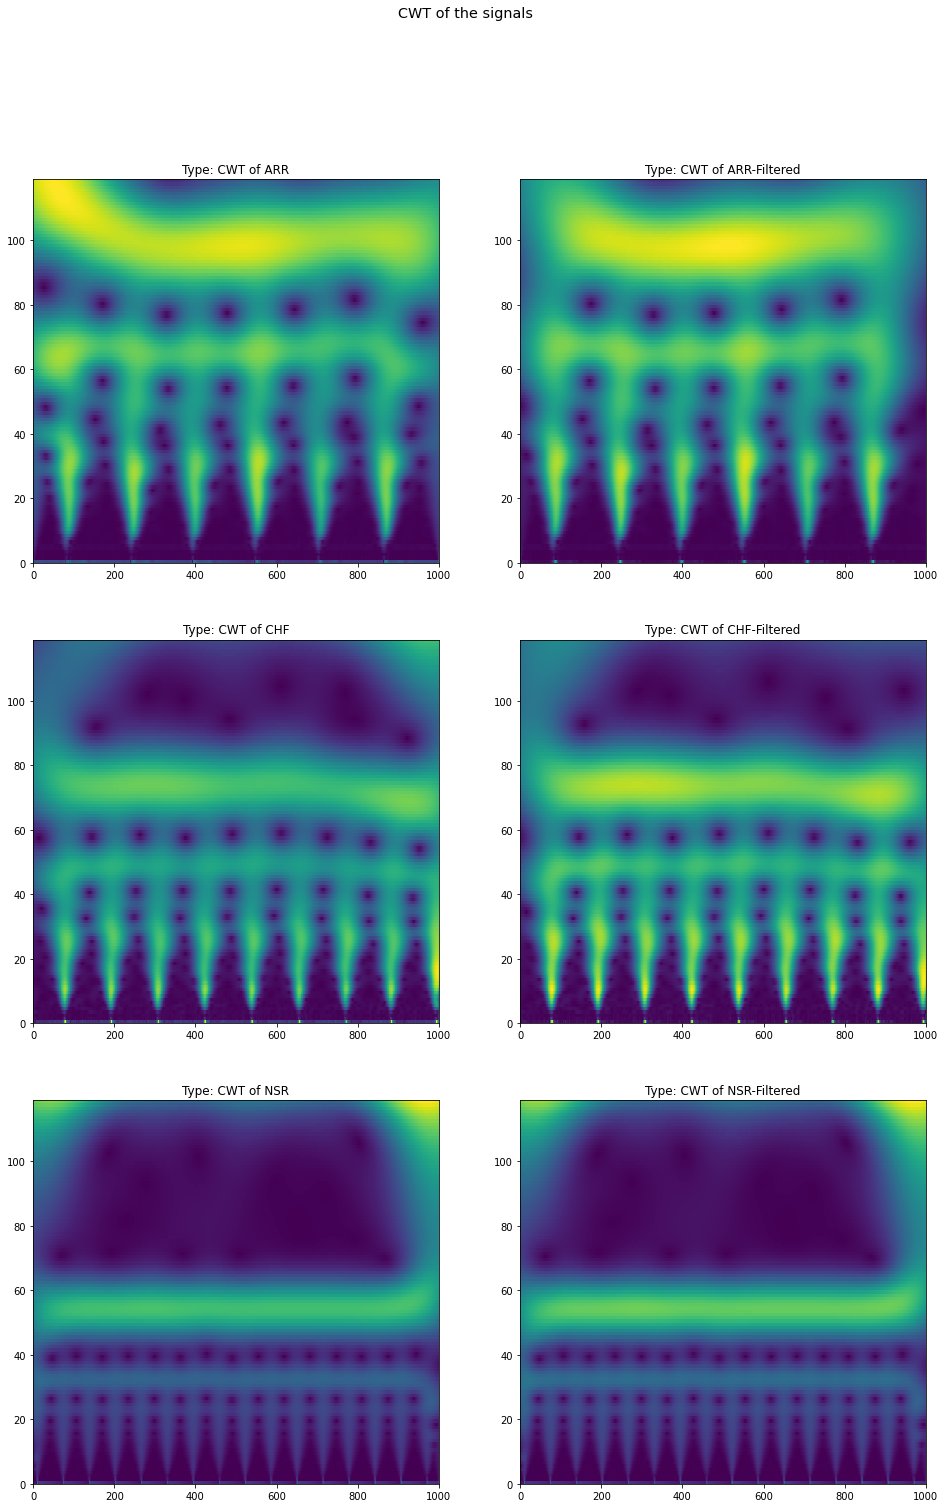

In [51]:
ind_ARR = np.random.randint(low = 0,high = sig_ARR.shape[0])
ind_CHF = np.random.randint(low = 0,high = sig_CHF.shape[0])
ind_NSR = np.random.randint(low = 0,high = sig_NSR.shape[0])

fig1 = plt.figure(1)
fig1, ax1 = plt.subplots(3,2)
fig1.suptitle("Signal", fontsize="x-large")
fig1.set_figheight(24)
fig1.set_figwidth(16)

fig2 = plt.figure(2)
fig2, ax2 = plt.subplots(3,2)
fig2.suptitle("CWT of the signals", fontsize="x-large")
fig2.set_figheight(24)
fig2.set_figwidth(16)

for i, ind in enumerate([ind_ARR, ind_CHF, ind_NSR]):
    if i ==0:
        sig = sig_ARR[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sigf)
        lab = lab_ARR[ind]
    elif i ==1:
        sig = sig_CHF[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sigf)
        lab = lab_CHF[ind]
    elif i ==2:
        sig = sig_NSR[ind]
        sigf = butter_highpass_filter(sig)
        sigf = notch_filter(sig)
        lab = lab_NSR[ind]       



    sig = sig[0:1000]
    sigf = sigf[0:1000]
    if(np.max(sig) < np.abs(np.min(sig)) ):
        sig = -1*sig
    if(np.max(sigf) < np.abs(np.min(sigf)) ):
        sigf = -1*sigf    
    cwt = signal.cwt(sig, signal.morlet2, widths=np.arange(1,120), w=8)
    cwtf = signal.cwt(sigf, signal.morlet2, widths=np.arange(1,120), w=8)
    

    ax1[i, 0].plot(sig)
    ax1[i, 0].set_title(f"Type: {lab}")
    ax1[i, 1].plot(sigf)
    ax1[i, 1].set_title(f"Type: {lab}-Filtered")

    ax2[i, 0].pcolormesh(np.abs(cwt))
    ax2[i, 0].set_title(f"Type: CWT of {lab}")
    ax2[i, 1].pcolormesh(np.abs(cwtf))
    ax2[i, 1].set_title(f"Type: CWT of {lab}-Filtered")

    print(f"Label: {lab}\tIndex: {ind}")

In [52]:
# for i in range(0, sig_NSR.shape[0]):
#     fig = plt.figure(figsize=(20,4))
#     plt.plot(sig_NSR[i][0:6000])
#     plt.title(i)
#     plt.plot(notch_filter(butter_highpass_filter(sig_NSR[i][0:6000])))

In [58]:
def process_signal(data):
    data = butter_highpass_filter(data)
    data = notch_filter(data)
    return data


def create_save_wavelets(data:np.ndarray, name:str):

    
    [os.makedirs(x, exist_ok=True) for x in ["Dataset/ARR", "Dataset/CHF", "Dataset/NSR"]]

    path = "Dataset/" + name.upper()

    if not os.path.isdir(path):
        assert NotADirectoryError(f"{path} is not a valid path")

    sig_len = data.shape[1]

    for i, sig in enumerate(data):
        
        if(np.max(sig) < np.abs(np.min(sig)) ):
            sig = -1*sig
        sig = process_signal(sig)

        start = [5000, 7000, 10000,13000,15000,17000, 20000,23000,25000,27000, 30000,33000,35000,37000, 40000,43000,45000,47000, 50000,53000,55000, 57000,60000]
        stop = [x+1000 for x in start]

        if name == "ARR":
            start = start[0::3]
            stop = [x+1000 for x in start]

        cnt = 0
        for k,l in zip(start, stop):
            imdir = path +"/"+ name+"_"+str(i)+"_"+str(cnt)+".png"
            cwt = signal.cwt(sig[k:l], signal.morlet2, widths=np.arange(1,81,80/1000), w=8)
            cwt = np.abs(cwt)
            cm = get_cmap('viridis')
            cwt = (cm(cwt)[:,:,:3]*255).astype(np.uint8)

            result = Image.fromarray(cwt)
            result = result.resize((224,224), resample = Image.LANCZOS)
            result.save(imdir, format="png")
            cnt += 1

create_save_wavelets(sig_NSR, "NSR")        
create_save_wavelets(sig_ARR, "ARR")
create_save_wavelets(sig_CHF, "CHF")        
     